In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
file_path = 'bndes-rates.csv'
bndes = pd.read_csv('bndes-rates.csv')

#### 1) Estimated BNDES rates v. Observed BNDES rates

In [6]:
bndes['date'] = pd.to_datetime(bndes['date'], format='%b-%y')

In [7]:
alpha_factors = {
    2018: 0.57,
    2019: 0.66,
    2020: 0.74,
    2021: 0.83,
    2022: 0.91,
    2023: 1.00,
    2024: 1.00
}

In [8]:
bndes['alpha'] = bndes['date'].dt.year.map(alpha_factors)

In [9]:
bndes['ntnb_5yr_yield_ma'] = bndes['ntnb_5yr_yield'].rolling(window=3).mean().shift(1)

In [10]:
bndes['est_bndes_tlp'] = bndes['alpha'] * bndes['ntnb_5yr_yield_ma']

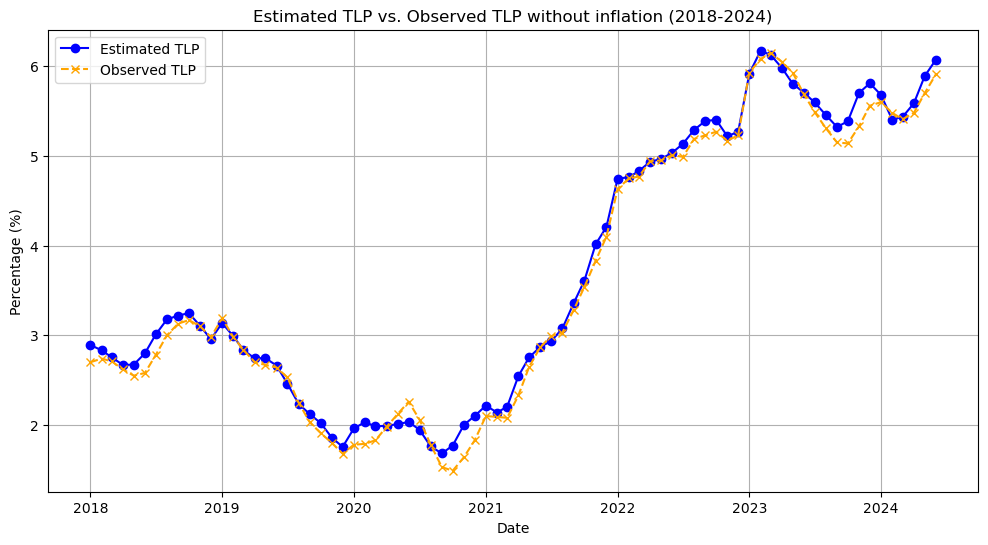

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(bndes['date'], bndes['est_bndes_tlp'], label='Estimated TLP', color='blue', marker='o')
plt.plot(bndes['date'], bndes['obs_bndes_tlp'], label='Observed TLP', color='orange', linestyle='--', marker='x')
plt.title('Estimated TLP vs. Observed TLP without inflation (2018-2024)')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

#### 2) Calculating BNDES rate

In [12]:
bndes['obs_tlp_ipca'] = bndes['cpi_ipca'].shift(1) + bndes['obs_bndes_tlp']   

In [13]:
bndes['bndes_rate'] = bndes['bndes_tjlp'].combine_first(bndes['obs_tlp_ipca'])

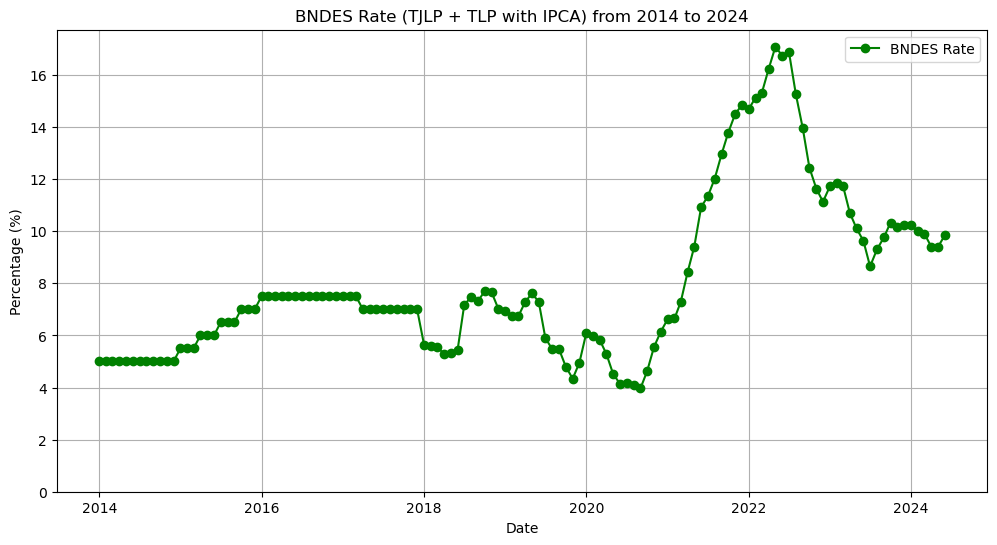

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(bndes['date'], bndes['bndes_rate'], label='BNDES Rate', color='green', marker='o')
plt.ylim(0, plt.ylim()[1])
plt.title('BNDES Rate (TJLP + TLP with IPCA) from 2014 to 2024')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print(bndes.columns)

Index(['date', 'bndes_tjlp', 'obs_bndes_tlp', 'ntnb_5yr_yield', 'cpi_ipca',
       'alpha', 'ntnb_5yr_yield_ma', 'est_bndes_tlp', 'obs_tlp_ipca',
       'bndes_rate'],
      dtype='object')


In [17]:
us_treasury_file_path = 'us-treasury-yield.csv'
us_treasury_data = pd.read_csv(us_treasury_file_path)

In [18]:
us_treasury_data['date'] = pd.to_datetime(us_treasury_data['date'], format='%b-%y')

In [19]:
bndes = pd.merge(bndes, us_treasury_data, on='date', how='left')

In [20]:
print(bndes.columns)

Index(['date', 'bndes_tjlp', 'obs_bndes_tlp', 'ntnb_5yr_yield', 'cpi_ipca',
       'alpha', 'ntnb_5yr_yield_ma', 'est_bndes_tlp', 'obs_tlp_ipca',
       'bndes_rate', 'us_treasury_yield'],
      dtype='object')


In [21]:
bndes['cds_brazil'] = bndes['bndes_rate'] - bndes['us_treasury_yield']

In [22]:
bndes[['date', 'bndes_rate', 'us_treasury_yield', 'cds_brazil']].tail()

,date,bndes_rate,us_treasury_yield,cds_brazil
121,2024-02-01,9.99,4.250,5.740
122,2024-03-01,9.91,4.200,5.710
123,2024-04-01,9.41,4.680,4.730
124,2024-05-01,9.39,4.499,4.891
125,2024-06-01,9.84,4.396,5.444


In [23]:
solar_capacity_file_path = 'solar-installed-capacity.csv'
solar_capacity_data = pd.read_csv(solar_capacity_file_path)

In [24]:
solar_capacity_data['date'] = pd.to_datetime(solar_capacity_data['date'], format='%b-%y')

In [25]:
bndes = pd.merge(bndes, solar_capacity_data, on='date', how='left')

In [26]:
print(bndes.columns)

Index(['date', 'bndes_tjlp', 'obs_bndes_tlp', 'ntnb_5yr_yield', 'cpi_ipca',
       'alpha', 'ntnb_5yr_yield_ma', 'est_bndes_tlp', 'obs_tlp_ipca',
       'bndes_rate', 'us_treasury_yield', 'cds_brazil',
       'solar_capacity_ratio'],
      dtype='object')


#### Adding the technology premium based on solar installed capacity

In [27]:
def calculate_technology_premium(solar_capacity_ratio):
    #For new markets a linear interpolation between 3.25% and 3% for 0% to <5% capacity
    if solar_capacity_ratio < 5:
        return 3.25 - (0.25 * (solar_capacity_ratio / 5))
    #For intermediate markets a linear interpolation between 3% and 1.7% for 5% to <10% capacity
    elif 5 <= solar_capacity_ratio < 10:
        return 3.0 - (1.3 * ((solar_capacity_ratio - 5) / 5))
    #For mature markets of 10% and above a fixed premium is assigned
    else:
        return 1.5

In [28]:
bndes['technology_premium'] = bndes['solar_capacity_ratio'].apply(calculate_technology_premium)

In [29]:
bndes[['date', 'solar_capacity_ratio', 'technology_premium']].head()

,date,solar_capacity_ratio,technology_premium
0,2014-01-01,0.011075,3.249446
1,2014-02-01,0.011098,3.249445
2,2014-03-01,0.012773,3.249361
3,2014-04-01,0.013002,3.249350
4,2014-05-01,0.014432,3.249278


In [30]:
print(bndes[['date', 'solar_capacity_ratio', 'technology_premium']].iloc[70:75])

         date  solar_capacity_ratio  technology_premium
70 2019-11-01              2.396256            3.130187
71 2019-12-01              2.609564            3.119522
72 2020-01-01              2.744649            3.112768
73 2020-02-01              2.882156            3.105892
74 2020-03-01              3.115713            3.094214


#### Calculating the pre-tax cost of debt (KD)

In [31]:
bndes['pre_tax_cost_of_debt'] = bndes['us_treasury_yield'] + bndes['cds_brazil'] + bndes['technology_premium']

#### Applying the tax shield to the KD

In [32]:
corporate_tax_rate = 0.34
bndes['cost_of_debt'] = bndes['pre_tax_cost_of_debt'] * (1 - corporate_tax_rate)

In [33]:
print(bndes[['date', 'pre_tax_cost_of_debt', 'cost_of_debt']].iloc[95:100])

         date  pre_tax_cost_of_debt  cost_of_debt
95 2021-12-01             17.237669     11.376861
96 2022-01-01             17.018646     11.232306
97 2022-02-01             17.404858     11.487206
98 2022-03-01             17.511049     11.557293
99 2022-04-01             18.347408     12.109289


#### Calculating the cost of equity (KE)

In [34]:
erp_file_path = 'erp-mature-market-sp500.csv'
erp_data = pd.read_csv(erp_file_path)

In [35]:
erp_data['date'] = pd.to_datetime(erp_data['date'], format='%b-%y')

In [36]:
bndes = pd.merge(bndes, erp_data, on='date', how='left')

In [37]:
print(bndes.columns)

Index(['date', 'bndes_tjlp', 'obs_bndes_tlp', 'ntnb_5yr_yield', 'cpi_ipca',
       'alpha', 'ntnb_5yr_yield_ma', 'est_bndes_tlp', 'obs_tlp_ipca',
       'bndes_rate', 'us_treasury_yield', 'cds_brazil', 'solar_capacity_ratio',
       'technology_premium', 'pre_tax_cost_of_debt', 'cost_of_debt',
       'erp_sp500'],
      dtype='object')


In [39]:
bndes['cost_of_equity'] = (
    bndes['us_treasury_yield'] +
    bndes['cds_brazil'] +
    bndes['erp_sp500'] +
    bndes['technology_premium']
)

In [40]:
bndes[['date', 'cost_of_debt','cost_of_equity']].iloc[95:100]

,date,cost_of_debt,cost_of_equity
95,2021-12-01,11.376861,22.027669
96,2022-01-01,11.232306,21.258646
97,2022-02-01,11.487206,21.964858
98,2022-03-01,11.557293,22.261049
99,2022-04-01,12.109289,23.077408


#### Cost of debt and cost of equity graph

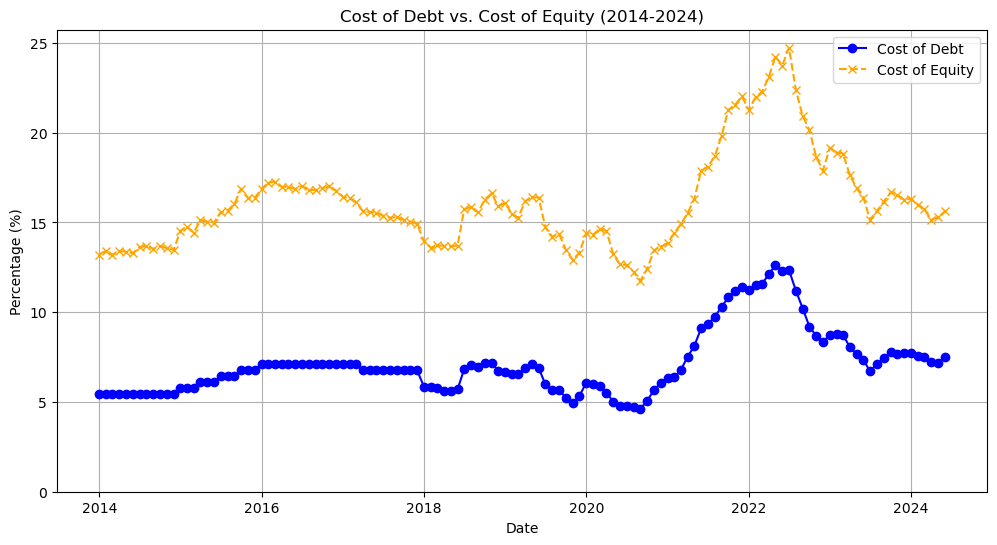

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(bndes['date'], bndes['cost_of_debt'], label='Cost of Debt', color='blue', marker='o')
plt.plot(bndes['date'], bndes['cost_of_equity'], label='Cost of Equity', color='orange', linestyle='--', marker='x')
plt.ylim(0, plt.ylim()[1])
plt.title('Cost of Debt vs. Cost of Equity (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

#### Debt share as per IRENA criteria (based on cumulative installed capacity)

In [42]:
def assign_debt_share(solar_capacity_ratio):
    #Mature market
    if solar_capacity_ratio >= 10:
        return 0.80
    #Intermediate market
    elif 5 <= solar_capacity_ratio < 10:
        return 0.70 
    #New market
    else:
        return 0.60

In [43]:
bndes['debt_share'] = bndes['solar_capacity_ratio'].apply(assign_debt_share)

#### Calculating cost of capital (WACC)

In [44]:
bndes['cost_of_capital'] = (
    bndes['cost_of_debt'] * bndes['debt_share'] +
    bndes['cost_of_equity'] * (1 - bndes['debt_share'])
)

In [45]:
bndes[['date', 'debt_share', 'cost_of_capital']].head()

,date,debt_share,cost_of_capital
0,2014-01-01,0.6,8.550559
1,2014-02-01,0.6,8.634558
2,2014-03-01,0.6,8.550492
3,2014-04-01,0.6,8.626483
4,2014-05-01,0.6,8.614426


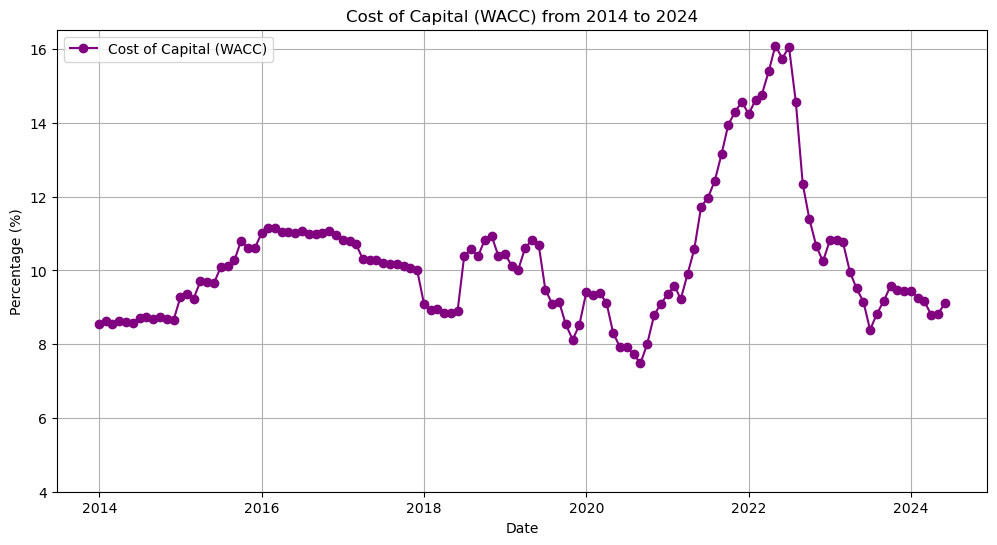

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(bndes['date'], bndes['cost_of_capital'], label='Cost of Capital (WACC)', color='purple', marker='o')
plt.ylim(4, plt.ylim()[1])
plt.title('Cost of Capital (WACC) from 2014 to 2024')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

#### Plotting against Selic Target Rate and bond yields

In [47]:
selic_bond_file_path = 'selic-and-bond-yields.csv'
selic_bond_data = pd.read_csv(selic_bond_file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'selic-and-bond-yields.csv'

In [ ]:
selic_bond_data['date'] = pd.to_datetime(selic_bond_data['date'], format='%b-%y')

In [ ]:
bndes = pd.merge(bndes, selic_bond_data, on='date', how='left')

In [ ]:
print(bndes.columns)

#### Adding additional historic data to the 'ntnb_5yr_yield' variable to compare similar periods

In [ ]:
bndes['ntnb_5yr_yield'].fillna(bndes['brl_5yr_bloomberg'], inplace=True)

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(bndes['date'], bndes['cost_of_capital'], label='Cost of Capital (WACC)', color='purple', linewidth=1.5)

plt.plot(bndes['date'], bndes['selic_target_rate'], label='Selic Rate (Brazil General Interest Rate)', color='blue', linestyle='--', alpha=0.5, linewidth=1.5)
plt.plot(bndes['date'], bndes['10yr_bloomberg_yield'], label='10-Year Bloomberg Yield', color='grey', linestyle='-.', alpha=0.5, linewidth=1.5)
plt.plot(bndes['date'], bndes['yr10_gov_bond_yield'], label='10-Year Government Bond Yield', color='grey', linestyle='-', marker='x', alpha=0.5, linewidth=1.5)
plt.plot(bndes['date'], bndes['ntnb_5yr_yield'], label='5-Year BRL Bond Yield (Updated)', color='grey', linestyle='-.', alpha=0.5, linewidth=1.5)
plt.ylim(0, plt.ylim()[1])
plt.title('WACC vs. Selic Rate and Bond Yields (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
bndes.to_csv('bndes_wacc_calculations.csv', index=False)

print(f"Data has been successfully saved as {'bndes_wacc_calculations.csv'}")

### Data Visualization

In [ ]:
import seaborn as sns

In [ ]:
sns.set_theme(style="whitegrid")

In [ ]:
plt.figure(figsize=(14,7))
sns.lineplot(data=bndes, x='date', y='us_treasury_yield', label='Global Risk-Free Rate (GRF)', marker='o')
sns.lineplot(data=bndes, x='date', y='cds_brazil', label='Country Default Spread (CDS)', marker='x')
sns.lineplot(data=bndes, x='date', y='technology_premium', label='Technology Premium (TP)', marker='s')
plt.title('Cost of Debt Components (Pre-Tax) from 2014 to 2024')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
dates = bndes['date']
grf = bndes['us_treasury_yield']
cds = bndes['cds_brazil']
tp = bndes['technology_premium']

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=grf, fill='tonexty', mode='none', name='Global Risk-Free Rate (GRF)', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=dates, y=grf + cds, fill='tonexty', mode='none', name='Country Default Spread (CDS)', line=dict(color='yellow')))
fig.add_trace(go.Scatter(x=dates, y=grf + cds + tp, fill='tonexty', mode='none', name='Technology Premium (TP)', line=dict(color='green')))

fig.update_layout(
    title='Cost of Debt Components (Pre-Tax) from 2014 to 2024',
    xaxis_title='Date',
    yaxis_title='Percentage (%)',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [ ]:
bndes['year'] = bndes['date'].dt.year
annual_wacc = bndes.groupby('year')['cost_of_capital'].mean().reset_index()
annual_wacc.columns = ['Year','Average WACC']
annual_wacc